# <center>**Machine Learning Assignment 1**</center>

<p style="text-align: center;"><strong>Name:</strong> Zaeem Raza</p>
<p style="text-align: center;"><strong>Roll Number:</strong> BCSF21M022</p>

## **Introduction**

In this assignment, the task is to train a model on an imbalanced dataset and then classify the images. The goal is to effectively handle the imbalance in the data and achieve accurate classification results.


## Importing necessary libraries

In this section, we import necessary libraries for data manipulation, model development, and evaluation. Key libraries include `torch` for deep learning, `PIL` for image processing, and `sklearn` for model evaluation metrics.

```

```


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import ResNet18_Weights
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import warnings

## <center>**1.Data Loading and Data Augmentation**<center>

In this section, we will load the dataset and perform data augmentation to increase the diversity of the training data without actually collecting new data. Data augmentation techniques such as rotation, flipping, and scaling will be applied to enhance the robustness of our model.


### Loading the Dataset

In this section, we define a custom dataset class named `HandwrittenMarksDataset` to handle the loading and preprocessing of the handwritten marks dataset. This class will inherit from `torch.utils.data.Dataset` and will include methods to load images, apply transformations, and return the necessary data for training and evaluation.


In [2]:
class HandwrittenMarksDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        
        self.root_dir = root_dir
        self.split = split 
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Define the split directory path
        split_dir = os.path.join(root_dir, self.split)

        # Iterate through the subdirectories (0, 0.5, 1, 1.5, ..., 7.5)
        for label in os.listdir(split_dir):
            label_path = os.path.join(split_dir, label)
            
            # Ensure that the path is a directory
            if os.path.isdir(label_path):
                
                # Iterate through the images (only .png files)
                for img in os.listdir(label_path):
                    if img.endswith('.png'):
                        # Append the image path and its corresponding label
                        self.image_paths.append(os.path.join(label_path, img))
                        self.labels.append(float(label))  # Convert the label (folder name) to a float

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Convert floating-point label to integer index 
        label = int(label / 0.5)  # Convert 0.0 -> 0, 0.5 -> 1, 1.0 -> 2, ...

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

`Define transforms for the dataset`

Data Augmentation and Normalization


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # ResNet18 takes 224x224 images
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Default ResNet mean and std
])

### Reason for Applying Transformations on Test Data

The `transform` is applied to the test data to ensure that the images are resized to 224x224 pixels, which is the required input size for the ResNet18 model. ResNet18 has a specific input architecture that necessitates images of this size for optimal performance. Additionally, normalization is applied to match the mean and standard deviation used during the training of the ResNet18 model, ensuring consistency and improving the accuracy of the model's predictions.


In [4]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

`Load the training dataset`


In [5]:
train_dataset = HandwrittenMarksDataset(root_dir='handwritten_marks_dataset', split='train', transform=transform)
test_dataset = HandwrittenMarksDataset(root_dir='handwritten_marks_dataset', split='test', transform=test_transform)

`Let's analyze what is the size of training dataset`


In [6]:
len(train_dataset), len(test_dataset)

(748, 926)

#### Visualize a batch of random images from a given dataset.

This function selects a specified number of random samples from the dataset, denormalizes the images, and displays them in a grid format along with their corresponding labels.


In [7]:
def visualize_samples(dataset, num_samples=5):
    indices = random.sample(range(len(dataset)), num_samples)
    
    # Prepare a grid to display the images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).numpy() 
        
        # Denormalize the image
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

        image = np.clip(image, 0, 1)
        
        # Reverse the label mapping (e.g., 0 -> 0.0, 1 -> 0.5, 2 -> 1.0, ...)
        original_label = label * 0.5

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f'Label: {original_label:.1f}') 
    
    plt.show()


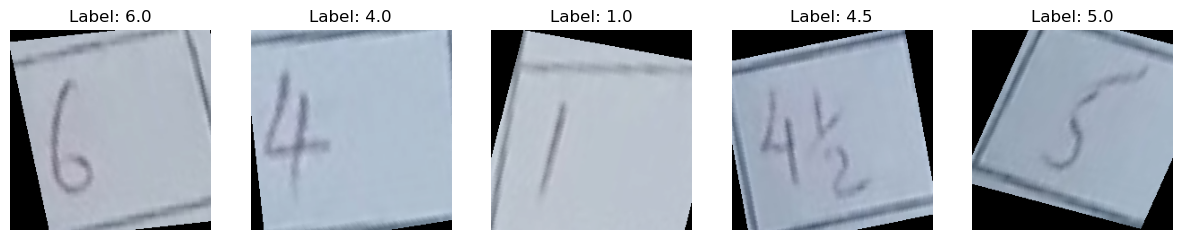

In [8]:
visualize_samples(train_dataset, num_samples=5)

# <center>**2.Split the data into Train and Validation set**<center>

In this section, we will split the training dataset into training and validation sets. This will help us evaluate the model's performance on unseen data during the training process and prevent overfitting.


In [9]:
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # No need to shuffle the validation set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # No need to shuffle the test set

#### Class Weights Calculation

In this section, we will calculate the class weights for handling the imbalanced dataset. Class weights are computed based on the frequency of each class in the training dataset. These weights will be used to adjust the loss function during training, giving more importance to the minority classes.


In [10]:
all_labels = [label for _, label in train_dataset]
label_counts = Counter(all_labels)
total_samples = len(all_labels)
class_weights = {label: total_samples / count for label, count in label_counts.items()}
weights = torch.tensor([class_weights.get(label, 1.0) for label in range(16)], dtype=torch.float)

## <center>**3. Model Development**<center>

In this section, we will develop a deep learning model using the ResNet-18 architecture. ResNet-18 is a widely used convolutional neural network (CNN) that has demonstrated excellent performance on various image classification tasks. The key advantage of ResNet-18 is its residual connections, which help mitigate the vanishing gradient problem and enable the training of deeper networks.

We will leverage the pre-trained ResNet-18 model available in the `torchvision` library and fine-tune it on our handwritten marks dataset. Fine-tuning a pre-trained model allows us to benefit from the knowledge the model has already acquired from a large dataset (e.g., ImageNet) and adapt it to our specific task, which can lead to faster convergence and improved performance.

The steps involved in this process include:

1. Loading the pre-trained ResNet-18 model.
2. Modifying the final fully connected layer to match the number of classes in our dataset.
3. Defining the loss function and optimizer.
4. Training the model on the training dataset and validating it on the validation dataset.
5. Evaluating the model's performance on the test dataset.

By using ResNet-18, we aim to achieve accurate classification of the handwritten marks while effectively handling the imbalance in the dataset through techniques such as class weighting and data augmentation.


`We will use Adam Optimizer with learning rate 0.0001`


In [11]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# <center>**4.Training the Model**<center>


The `train_model` function trains and evaluates a deep learning model over a specified number of epochs. It handles both training and validation phases, computing loss and accuracy for each.

#### Parameters:

- **`model`**: The model to be trained (e.g., neural network).
- **`train_loader`**: DataLoader for the training dataset.
- **`val_loader`**: DataLoader for the validation dataset.
- **`criterion`**: The loss function (e.g., `CrossEntropyLoss`).
- **`optimizer`**: The optimization algorithm (e.g., `Adam`).
- **`num_epochs`**: Number of epochs to train (default is 10).

#### Workflow:

1. **Training Phase**:

   - The model is set to training mode (`model.train()`).
   - For each batch, the model computes predictions, calculates loss, and updates parameters using backpropagation.
   - Gradient clipping prevents exploding gradients.

2. **Validation Phase**:
   - After each epoch, the model is evaluated on the validation set (`model.eval()`), with loss and accuracy reported.

#### Key Features:

- **Gradient Clipping**: Prevents instability by limiting the gradient magnitude.
- **Loss & Accuracy Reporting**: Provides feedback on both training and validation performance.

This function efficiently trains and monitors the model over multiple epochs, handling both training and validation seamlessly.


`A helper function plot_metrics to visualize the model's performance`


In [12]:
    
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epochs')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Epochs')

    # Show the plots
    plt.tight_layout()
    plt.show()

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    print("Training the model")
    print("-" * 30)

    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Training Phase
        model.train()
        running_loss = 0.0
        corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Convert labels to Long before passing to the criterion
            labels = labels.long()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / len(train_loader.dataset)

        # Store training loss and accuracy
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation Phase
        model.eval()
        running_loss = 0.0
        corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                corrects += torch.sum(preds == labels.data)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = corrects.double() / len(val_loader.dataset)

        # Store validation loss and accuracy
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f"Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Plotting the results
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)




Training the model
------------------------------
Epoch 1/10
----------
Train Loss: 2.6743 Acc: 0.1455
Validation Loss: 2.1968 Acc: 0.3733
Epoch 2/10
----------
Train Loss: 1.1706 Acc: 0.7860
Validation Loss: 1.2589 Acc: 0.8067
Epoch 3/10
----------
Train Loss: 0.3640 Acc: 0.9682
Validation Loss: 0.7104 Acc: 0.8867
Epoch 4/10
----------
Train Loss: 0.0847 Acc: 0.9950
Validation Loss: 0.5698 Acc: 0.9200
Epoch 5/10
----------
Train Loss: 0.0216 Acc: 1.0000
Validation Loss: 0.4061 Acc: 0.9467
Epoch 6/10
----------
Train Loss: 0.0095 Acc: 1.0000
Validation Loss: 0.3300 Acc: 0.9600
Epoch 7/10
----------
Train Loss: 0.0057 Acc: 1.0000
Validation Loss: 0.3321 Acc: 0.9600
Epoch 8/10
----------
Train Loss: 0.0038 Acc: 1.0000
Validation Loss: 0.3029 Acc: 0.9733
Epoch 9/10
----------
Train Loss: 0.0035 Acc: 1.0000
Validation Loss: 0.3220 Acc: 0.9533
Epoch 10/10
----------
Train Loss: 0.0031 Acc: 1.0000
Validation Loss: 0.2996 Acc: 0.9667


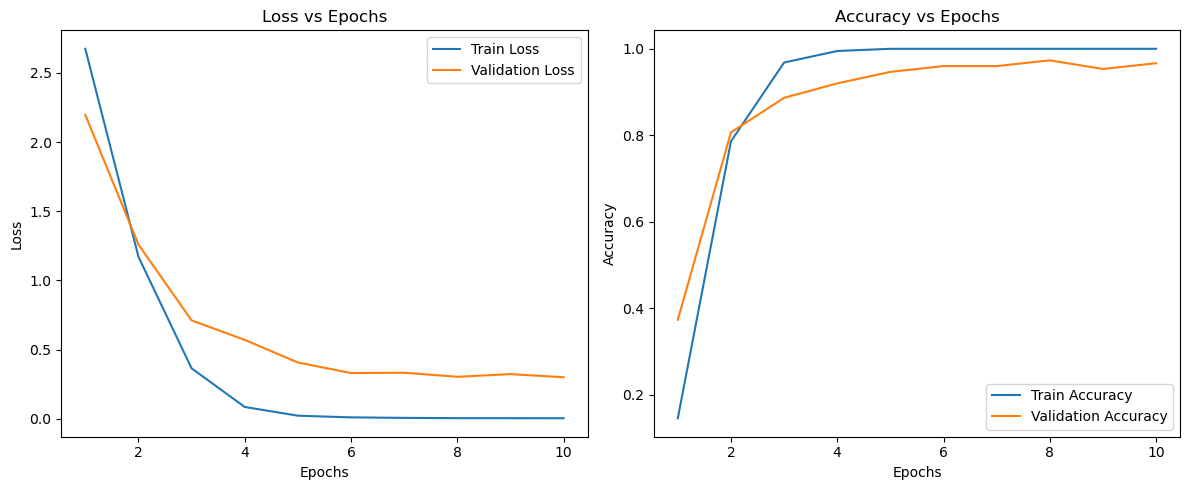

In [14]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# <center>**5.Evaluation**<center>


### Model Evaluation

The `evaluate_model` function is used to evaluate the performance of the trained model on the test dataset. It calculates the following metrics:

1. **Test Loss and Accuracy**:
   - The average loss and accuracy of the model on the test set.
2. **Classification Report**:

   - This includes key metrics such as **Precision**, **Recall**, and **F1 Score** for each class, as well as the **weighted average** of these metrics across all classes.

3. **Confusion Matrix**:
   - A heatmap of the confusion matrix is displayed, providing insights into how well the model is performing across different classes. It shows the true vs predicted class labels.
4. **Additional Metrics**:
   - **Accuracy**: Proportion of correct predictions out of total samples.
   - **Precision**: Proportion of positive predictions that were correct.
   - **Recall**: Proportion of actual positives that were correctly identified.
   - **F1 Score**: The harmonic mean of precision and recall, providing a balanced measure of performance, especially for imbalanced datasets.


In [15]:
warnings.filterwarnings("ignore") # Ignore warnings division by zero

In [16]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    target_labels=[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5]
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            # Store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Calculate average test loss and accuracy
        test_loss = running_loss / total_samples
        test_acc = corrects.double() / total_samples
        print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

    print("\nClassification Report:\n", classification_report(all_labels, all_preds,target_names=[str(label) for label in target_labels]))

    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix using seaborn for better visualization
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(0, 8, 0.5), yticklabels=np.arange(0, 8, 0.5))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

    accuracy = accuracy_score(all_labels, all_preds)

    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")

In [17]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Test Loss: 0.3103 Acc: 0.9417

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.98        85
         0.5       0.00      0.00      0.00         6
         1.0       0.83      1.00      0.91        25
         1.5       0.56      0.71      0.62         7
         2.0       0.95      1.00      0.98        62
         2.5       0.91      0.57      0.70        35
         3.0       0.98      0.98      0.98        54
         3.5       0.60      1.00      0.75        24
         4.0       0.99      0.99      0.99       100
         4.5       0.68      0.95      0.79        20
         5.0       0.99      1.00      1.00       322
         5.5       0.77      0.83      0.80        12
         6.0       0.93      1.00      0.97        99
         6.5       1.00      0.62      0.77        16
         7.0       1.00      0.86      0.92        49
         7.5       0.00      0.00      0.00        10

    accuracy             

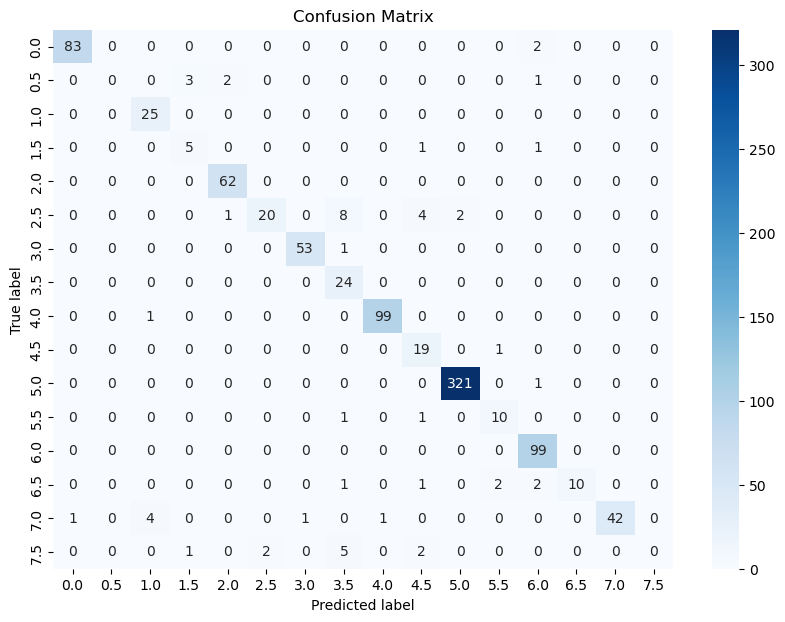


Accuracy: 0.9417
Precision (weighted): 0.9356
Recall (weighted): 0.9417
F1 Score (weighted): 0.9339


In [18]:
evaluate_model(model, test_loader, criterion)

`Let's visualize some samples`


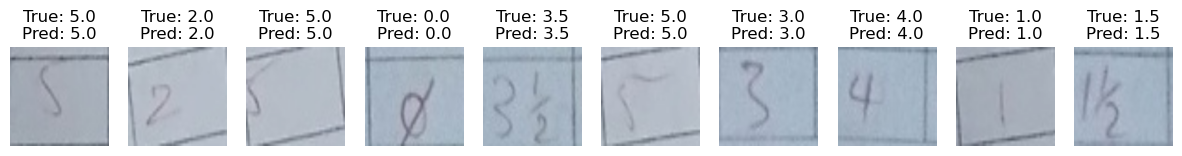

In [19]:
def visualize_predictions(model, dataset, num_samples=5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    
    # Prepare a grid to display the images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = dataset[idx]
            image = image.unsqueeze(0).to(device)
            
            # Get model prediction
            output = model(image)
            _, pred_label = torch.max(output, 1)
            
            # Convert image back to numpy for plotting
            image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
            
            # Denormalize the image
            image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Reverse normalization

            # Clip the values to be in [0, 1] range
            image = np.clip(image, 0, 1)
            
            # Reverse the label mapping (e.g., 0 -> 0.0, 1 -> 0.5, 2 -> 1.0, ...)
            original_true_label = true_label * 0.5
            original_pred_label = pred_label.item() * 0.5
            
            # Display image
            axes[i].imshow(image)
            axes[i].axis('off')
            axes[i].set_title(f'True: {original_true_label:.1f}\nPred: {original_pred_label:.1f}')
    
    plt.show()

# Visualize predictions on the test dataset
visualize_predictions(model, test_dataset, num_samples=10)

`Save the model state`


In [20]:
torch.save(model.state_dict(), 'model.pth')
print("Model saved to model.pth")

Model saved to model.pth


# <center>**6.Analysis And Reflection**<center>


### **a.Impact of Imbalanced dataset**


Working with a highly imbalanced dataset of images presents several challenges:

1. **Bias Towards Majority Class**: The model tends to predict the majority class more frequently.
2. **Poor Generalization**: The model struggles to generalize well to minority classes.
3. **Misleading Accuracy**: High accuracy may not reflect true performance due to class imbalance.
4. **Difficulty in Model Training**: Imbalance complicates the training process and hyperparameter tuning.
5. **Evaluation Challenges**: Metrics like accuracy can be misleading; precision, recall, and F1 score are more informative.
6. **Increased Risk of Overfitting**: The model may overfit to the majority class, neglecting minority classes.

##### **Challenges Faced**

- **Class Imbalance**: Disproportionate number of images per class led to biased predictions.
- **Poor Performance on Minority Classes**: Despite techniques like class weighting and data augmentation, the model struggled with minority classes.
- **Hyperparameter Tuning**: Imbalance caused instability, requiring more epochs and fine-tuning.
- **Confusion with Metrics**: Accuracy was unreliable; precision, recall, and F1 score were more meaningful.
- **Model Overfitting**: Risk of overfitting to the majority class, mitigated by dropout and regularization.


### **b.Effectiveness of Data Augmentation**


Data augmentation significantly improved the model's performance on the imbalanced dataset by artificially increasing the diversity of the training data. Techniques such as rotation, flipping, scaling, and random affine transformations helped the model generalize better by exposing it to a wider variety of image variations. This not only mitigated the overfitting to the majority class but also enhanced the model's ability to recognize and correctly classify images from minority classes, leading to a more balanced and robust performance across all classes.


### **c.Improvements and Extensions**


- **Collect More Data**: Gather additional samples for minority classes to balance the dataset.
- **Advanced Data Augmentation**: Apply more sophisticated augmentation techniques like CutMix or MixUp.
- **Different Architectures**: Experiment with other architectures like EfficientNet or DenseNet.
- **Hyperparameter Tuning**: Try different learning rates, optimizers (e.g., SGD, RMSprop), and batch sizes.
- **Class Imbalance Techniques**: Use techniques like SMOTE or ADASYN to generate synthetic samples for minority classes.
- **Ensemble Methods**: Combine predictions from multiple models to improve overall performance.
- **Regularization**: Implement techniques like dropout, weight decay, or early stopping to prevent overfitting.
- **Transfer Learning**: Fine-tune models pre-trained on similar tasks or larger datasets.
- **Cross-Validation**: Use k-fold cross-validation to ensure robust evaluation and better generalization.
